First we need all our imports

In [1]:
import os
import glob
import re
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import toolz.curried as tl


In [2]:
DATA_FILES = glob.glob(os.path.join(os.getcwd(), "data", "original_data", "*.xls*"))

In [3]:
print(*map(os.path.basename, DATA_FILES))

Houston_Complete_Sorted.xlsm Limestone_Complete_Sorted.xlsm Madison_Irrigated_2.xls Madison_Rainfed_2.xls


Quickly looking through the data in excel we can see that madison is separated into two files for rainfed and irrigated where as houston and limestone have a column for a flag to tell if it is rainfed or irrigated. First step is to get all the files to have similar formats so I will aggregate the two madison files into one.

In [4]:
def find_file(regex, files):
    for file in files:
        if re.search(regex, file):
            return file
    raise ValueError("No File Found.")

In [5]:
madison_rf_df = pd.read_excel(find_file(r".*Madison_Rain.*", DATA_FILES))
limestone_df = pd.read_excel(find_file(r".*Limestone.*", DATA_FILES))
houston_df = pd.read_excel(find_file(r".*Houston.*", DATA_FILES))
madison_irr_df = pd.read_excel(find_file(r".*Madison_Irr.*", DATA_FILES))

In [6]:
rf_cols = sorted(madison_rf_df.columns)
irr_cols = sorted(madison_irr_df.columns)
for i in range(len(rf_cols)):
    if rf_cols[i] != irr_cols[i]:
        print(f"index {i}\n{rf_cols[i]} != {irr_cols[i]}")

In [7]:
madison_rf_df["rf_irr"] = 0
madison_irr_df["rf_irr"] = 1

In [8]:
madison_rf_df.head()

,Longitude,Latitude,MOD13Q1_006__250m_16_days_EVI_doy2011081_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012081_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011097_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011113_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011129_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011145_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011161_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011177_aid0001_tif,...,MOD13Q1_006__250m_16_days_EVI_doy2012113_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012129_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012145_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012161_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012177_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012193_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012209_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012225_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012241_aid0001_tif,rf_irr
0,-86.779999,34.990601,3413,3747,4421,3276,2311,2988,2734,4211,...,3416,2782,4794,5903,4964,5358.0,5287.0,3766,3680.0,0
1,-86.777496,34.990601,3281,3747,4421,3276,2445,3072,3030,4211,...,3400,3202,5065,4745,4172,4764.0,4815.0,3797,3916.0,0
2,-86.764801,34.990601,4045,4696,4981,4962,3469,4083,3838,5155,...,4230,3126,4240,5217,3612,5986.0,5905.0,4957,3974.0,0
3,-86.757202,34.990601,4167,5114,5000,3959,4367,3958,3031,3781,...,4808,4320,5187,4801,4535,5090.0,4958.0,4200,3011.0,0
4,-86.754600,34.990601,4256,5114,5000,3822,3801,2854,2302,3863,...,3525,3904,5480,5388,4324,4456.0,4866.0,3261,3443.0,0


In [9]:
madison_df = pd.concat([madison_rf_df, madison_irr_df], sort=False)
madison_df["county"] = "Madison"

In [10]:
madison_rf_df.info()
madison_irr_df.info()
madison_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5053 entries, 0 to 5052
Data columns (total 25 columns):
Longitude                                               5053 non-null float64
Latitude                                                5053 non-null float64
MOD13Q1_006__250m_16_days_EVI_doy2011081_aid0001_tif    5053 non-null int64
MOD13Q1_006__250m_16_days_EVI_doy2012081_aid0001_tif    5053 non-null int64
MOD13Q1_006__250m_16_days_EVI_doy2011097_aid0001_tif    5053 non-null int64
MOD13Q1_006__250m_16_days_EVI_doy2011113_aid0001_tif    5053 non-null int64
MOD13Q1_006__250m_16_days_EVI_doy2011129_aid0001_tif    5053 non-null int64
MOD13Q1_006__250m_16_days_EVI_doy2011145_aid0001_tif    5053 non-null int64
MOD13Q1_006__250m_16_days_EVI_doy2011161_aid0001_tif    5053 non-null int64
MOD13Q1_006__250m_16_days_EVI_doy2011177_aid0001_tif    5053 non-null int64
MOD13Q1_006__250m_16_days_EVI_doy2011193_aid0001_tif    5051 non-null float64
MOD13Q1_006__250m_16_days_EVI_doy2011209_aid0001_ti

In [11]:
madison_df.head()

,Longitude,Latitude,MOD13Q1_006__250m_16_days_EVI_doy2011081_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012081_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011097_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011113_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011129_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011145_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011161_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2011177_aid0001_tif,...,MOD13Q1_006__250m_16_days_EVI_doy2012129_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012145_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012161_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012177_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012193_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012209_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012225_aid0001_tif,MOD13Q1_006__250m_16_days_EVI_doy2012241_aid0001_tif,rf_irr,county
0,-86.779999,34.990601,3413,3747,4421,3276,2311,2988,2734,4211,...,2782,4794,5903,4964,5358.0,5287.0,3766,3680.0,0,Madison
1,-86.777496,34.990601,3281,3747,4421,3276,2445,3072,3030,4211,...,3202,5065,4745,4172,4764.0,4815.0,3797,3916.0,0,Madison
2,-86.764801,34.990601,4045,4696,4981,4962,3469,4083,3838,5155,...,3126,4240,5217,3612,5986.0,5905.0,4957,3974.0,0,Madison
3,-86.757202,34.990601,4167,5114,5000,3959,4367,3958,3031,3781,...,4320,5187,4801,4535,5090.0,4958.0,4200,3011.0,0,Madison
4,-86.754600,34.990601,4256,5114,5000,3822,3801,2854,2302,3863,...,3904,5480,5388,4324,4456.0,4866.0,3261,3443.0,0,Madison


In [12]:
houston_df.head()

,X,Y,Unnamed: 2,Unnamed: 3,RF_Irr,EVI_2011_Apr_7_Houston_tif_rf_1,EVI_2011_Apr_23_Houston_tif_rf,EVI_2011_May_9_Houston_tif_rf,EVI_2011_May_25_Houston_tif_rf,EVI_2011_Jun_10_Houston_tif_rf,...,EVI_2012_Apr_6_Houston_tif_rf,EVI_2012_Apr_22_Houston_tif_rf,EVI_2012_May_8_Houston_tif_rf,EVI_2012_May_24_Houston_tif_rf,EVI_2012_Jun_9_Houston_tif_rf,EVI_2012_Jun_25_Houston_tif_rf,EVI_2012_Jul_11_Houston_tif_rf,EVI_2012_Jul_27_Houston_tif_rf,EVI_2012_Aug_12_Houston_tif_rf,EVI_2012_Aug_28_Houston_tif_rf
0,651082,3.46556e+06,31.314623,-85.412285,0.0,2800,3114,1873,2989,3299,...,4270,3417,2958,2656,4659,3069,5409,5876,5800,5738
1,653630,3.46556e+06,31.314289,-85.385513,0.0,1530,1453,1416,1364,1703,...,1699,1418,1523,1683,2726,2976,4179,4016,5509,4558
2,653862,3.46556e+06,31.314259,-85.383079,0.0,2076,1500,1602,2063,1703,...,1435,1754,1960,1926,2726,2976,4364,4848,4623,5547
3,651082,3.46533e+06,31.312532,-85.412315,0.0,2029,1400,1877,1343,1788,...,3220,1678,2599,2452,2149,2710,3564,5173,6491,6901
4,652009,3.46533e+06,31.312412,-85.402580,0.0,1854,2119,1611,1549,2393,...,1547,1861,1993,2278,4305,4462,4609,5122,5654,5367


In [13]:
houston_df = houston_df.rename(columns = {"RF_Irr":"rf_irr", "Unnamed: 2":"Latitude", "Unnamed: 3": "Longitude"})
houston_df["county"] = "Houston"

In [14]:
houston_df.head()

,X,Y,Latitude,Longitude,rf_irr,EVI_2011_Apr_7_Houston_tif_rf_1,EVI_2011_Apr_23_Houston_tif_rf,EVI_2011_May_9_Houston_tif_rf,EVI_2011_May_25_Houston_tif_rf,EVI_2011_Jun_10_Houston_tif_rf,...,EVI_2012_Apr_22_Houston_tif_rf,EVI_2012_May_8_Houston_tif_rf,EVI_2012_May_24_Houston_tif_rf,EVI_2012_Jun_9_Houston_tif_rf,EVI_2012_Jun_25_Houston_tif_rf,EVI_2012_Jul_11_Houston_tif_rf,EVI_2012_Jul_27_Houston_tif_rf,EVI_2012_Aug_12_Houston_tif_rf,EVI_2012_Aug_28_Houston_tif_rf,county
0,651082,3.46556e+06,31.314623,-85.412285,0.0,2800,3114,1873,2989,3299,...,3417,2958,2656,4659,3069,5409,5876,5800,5738,Houston
1,653630,3.46556e+06,31.314289,-85.385513,0.0,1530,1453,1416,1364,1703,...,1418,1523,1683,2726,2976,4179,4016,5509,4558,Houston
2,653862,3.46556e+06,31.314259,-85.383079,0.0,2076,1500,1602,2063,1703,...,1754,1960,1926,2726,2976,4364,4848,4623,5547,Houston
3,651082,3.46533e+06,31.312532,-85.412315,0.0,2029,1400,1877,1343,1788,...,1678,2599,2452,2149,2710,3564,5173,6491,6901,Houston
4,652009,3.46533e+06,31.312412,-85.402580,0.0,1854,2119,1611,1549,2393,...,1861,1993,2278,4305,4462,4609,5122,5654,5367,Houston


In [15]:
limestone_df.head()

,X,Y,Latitude,Longitude,Irr_Rf,EVI_2011_APR_7_1,EVI_2011_APR_23_,EVI_2011_MAY_9_L,EVI_2011_MAY_25_,EVI_2011_JUN_10_,...,EVI_2012_APR_6_L,EVI_2012_APR_22_,EVI_2012_MAY_8_L,EVI_2012_MAY_24_,EVI_2012_JUN_9_L,EVI_2012_JUN_25_,EVI_2012_JUL_11_,EVI_2012_JUL_27_,EVI_2012_AUG_12_,EVI_2012_AUG_28_
0,481294,3.86912e+06,34.964485,-87.204903,0.0,3703,4247,4079,4472,4666,...,5079,4006,2625,3389,3895,3660,6504,7270,6466,6445
1,497047,3.86912e+06,34.964657,-87.032349,0.0,3256,2695,2804,5184,3607,...,2830,3187,3997,4780,4882,3973,4344,4928,3651,6758
2,497510,3.86912e+06,34.964657,-87.027275,0.0,2983,3032,5763,2620,4831,...,2643,3491,3357,4701,4137,3710,4007,4268,4408,2721
3,480831,3.86889e+06,34.962391,-87.209976,0.0,3253,4592,4797,5969,3677,...,3875,4541,3599,4573,4612,4019,5942,5880,6815,5641
4,497278,3.86889e+06,34.962566,-87.029808,0.0,3483,3010,4030,2521,2799,...,3308,3166,3811,5268,4506,3898,6482,4144,3887,2598


In [16]:
limestone_df = limestone_df.rename(columns={"Irr_Rf":"rf_irr"})
limestone_df["county"] = "Limestone"
limestone_df.head()

,X,Y,Latitude,Longitude,rf_irr,EVI_2011_APR_7_1,EVI_2011_APR_23_,EVI_2011_MAY_9_L,EVI_2011_MAY_25_,EVI_2011_JUN_10_,...,EVI_2012_APR_22_,EVI_2012_MAY_8_L,EVI_2012_MAY_24_,EVI_2012_JUN_9_L,EVI_2012_JUN_25_,EVI_2012_JUL_11_,EVI_2012_JUL_27_,EVI_2012_AUG_12_,EVI_2012_AUG_28_,county
0,481294,3.86912e+06,34.964485,-87.204903,0.0,3703,4247,4079,4472,4666,...,4006,2625,3389,3895,3660,6504,7270,6466,6445,Limestone
1,497047,3.86912e+06,34.964657,-87.032349,0.0,3256,2695,2804,5184,3607,...,3187,3997,4780,4882,3973,4344,4928,3651,6758,Limestone
2,497510,3.86912e+06,34.964657,-87.027275,0.0,2983,3032,5763,2620,4831,...,3491,3357,4701,4137,3710,4007,4268,4408,2721,Limestone
3,480831,3.86889e+06,34.962391,-87.209976,0.0,3253,4592,4797,5969,3677,...,4541,3599,4573,4612,4019,5942,5880,6815,5641,Limestone
4,497278,3.86889e+06,34.962566,-87.029808,0.0,3483,3010,4030,2521,2799,...,3166,3811,5268,4506,3898,6482,4144,3887,2598,Limestone


In [17]:
@tl.curry
def tokenize(delimiter, string):
    return string.split(delimiter)
tokenizer = tokenize("_")
limestone_tokenized = list(tl.map(tokenizer, limestone_df.columns))
houston_tokenized = list(tl.map(tokenizer, houston_df.columns))
madison_tokenized = list(tl.map(tokenizer, madison_df.columns))
print("limestone")
for tk in limestone_tokenized:
    print(tk)
print("houston")
for tk in houston_tokenized:
    print(tk)
print("madison")
for tk in madison_tokenized:
    print(tk)

limestone
['X']
['Y']
['Latitude']
['Longitude']
['rf', 'irr']
['EVI', '2011', 'APR', '7', '1']
['EVI', '2011', 'APR', '23', '']
['EVI', '2011', 'MAY', '9', 'L']
['EVI', '2011', 'MAY', '25', '']
['EVI', '2011', 'JUN', '10', '']
['EVI', '2011', 'JUN', '26', '']
['EVI', '2011', 'JUL', '12', '']
['EVI', '2011', 'JUL', '28', '']
['EVI', '2011', 'AUG', '13', '']
['EVI', '2011', 'AUG', '29', '']
['EVI', '2012', 'APR', '6', 'L']
['EVI', '2012', 'APR', '22', '']
['EVI', '2012', 'MAY', '8', 'L']
['EVI', '2012', 'MAY', '24', '']
['EVI', '2012', 'JUN', '9', 'L']
['EVI', '2012', 'JUN', '25', '']
['EVI', '2012', 'JUL', '11', '']
['EVI', '2012', 'JUL', '27', '']
['EVI', '2012', 'AUG', '12', '']
['EVI', '2012', 'AUG', '28', '']
['county']
houston
['X']
['Y']
['Latitude']
['Longitude']
['rf', 'irr']
['EVI', '2011', 'Apr', '7', 'Houston', 'tif', 'rf', '1']
['EVI', '2011', 'Apr', '23', 'Houston', 'tif', 'rf']
['EVI', '2011', 'May', '9', 'Houston', 'tif', 'rf']
['EVI', '2011', 'May', '25', 'Houston', 'ti

From the tokenizers we can see that houston and limestone report date of data in columns 2, 3, 4 of tokenized output (after skipping initial rows). All dates have to hape EVI in their tokenized output. Madison uses a day of year number. Now to move all the data into a consistent format.

In [18]:
def get_date_time(tokenized_list, county):
    
    def convert_month(month):

        return {
            'jan' : "01",
            'feb' : "02",
            'mar' : "03",
            'apr' : "04",
            'may' : "05",
            'jun' : "06",
            'jul' : "07",
            'aug' : "08",
            'sep' : "09", 
            'oct' : "10",
            'nov' : "11",
            'dec' : "12"
        }[month.lower()]

    if "EVI" not in tokenized_list:
        raise ValueError("EVI not found in tokenized list. Incorrect column name being used.")

    if county != "Madison":
        return tokenized_list[1] + "-" + convert_month(tokenized_list[2]) + "-" + tokenized_list[3].zfill(2)
    else:
        year = tokenized_list[7][3:7]
        day = tokenized_list[7][7:]
        first_day = datetime.date(int(year), 1, 1)
        date = first_day + datetime.timedelta(int(day))
        return str(date.year) + "-" + str(date.month).zfill(2) + "-" + str(date.day).zfill(2)

In [19]:
def convert_cols(columns, county):
    cols = []
    for col in columns:
        tokenized = tokenize("_", col)
        if "EVI" in tokenized:
            cols.append(get_date_time(tokenized, county))
        else:
            cols.append(col)
    return cols

In [20]:
madison_df.columns = convert_cols(madison_df.columns, "Madison")
houston_df.columns = convert_cols(houston_df.columns, "Houston")
limestone_df.columns = convert_cols(limestone_df.columns, "Limestone")

In [21]:
limestone_df = limestone_df.drop(columns=["X", "Y"])
houston_df = houston_df.drop(columns=["X", "Y"])

In [22]:
print(limestone_df.columns)
print(houston_df.columns)
print(madison_df.columns)

Index(['Latitude', 'Longitude', 'rf_irr', '2011-04-07', '2011-04-23',
       '2011-05-09', '2011-05-25', '2011-06-10', '2011-06-26', '2011-07-12',
       '2011-07-28', '2011-08-13', '2011-08-29', '2012-04-06', '2012-04-22',
       '2012-05-08', '2012-05-24', '2012-06-09', '2012-06-25', '2012-07-11',
       '2012-07-27', '2012-08-12', '2012-08-28', 'county'],
      dtype='object')
Index(['Latitude', 'Longitude', 'rf_irr', '2011-04-07', '2011-04-23',
       '2011-05-09', '2011-05-25', '2011-06-10', '2011-06-26', '2011-07-12',
       '2011-07-28', '2011-08-13', '2011-08-29', '2012-04-06', '2012-04-22',
       '2012-05-08', '2012-05-24', '2012-06-09', '2012-06-25', '2012-07-11',
       '2012-07-27', '2012-08-12', '2012-08-28', 'county'],
      dtype='object')
Index(['Longitude', 'Latitude', '2011-03-23', '2012-03-22', '2011-04-08',
       '2011-04-24', '2011-05-10', '2011-05-26', '2011-06-11', '2011-06-27',
       '2011-07-13', '2011-07-29', '2011-08-14', '2011-08-30', '2012-04-07',
      

Looking at the columns of the three dataframe we can see that madison has two extra datapoint (2011-03-23 and 2011-03-22). Also the madison dates are each one day ahead of the houston and limestone days. One day makes little difference in the span of vegetation, so I will subtract one from each madison day in order to make all the column names lineup. I will also choose to drop the two extraneous days in the madison data to make all the data match up (considering there are still plenty of days for all three datasets, I do not believe this drop will have a large affect).

In [23]:
new_cols = []
for col in madison_df.columns:
    if col[0] == "2":
        tk = tokenize("-", col)
        tk[2] = str(int(tk[2])-1).zfill(2)
        new_cols.append("-".join(tk))
    else:
        new_cols.append(col)

In [24]:
madison_df.columns = new_cols
madison_df = madison_df.drop(columns=["2011-03-22", "2012-03-21"])

In [25]:
all_df = pd.concat([madison_df, houston_df, limestone_df], sort=False)

In [26]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14677 entries, 0 to 6730
Data columns (total 24 columns):
Longitude     14675 non-null float64
Latitude      14675 non-null float64
2011-04-07    14677 non-null object
2011-04-23    14677 non-null object
2011-05-09    14677 non-null object
2011-05-25    14677 non-null object
2011-06-10    14677 non-null object
2011-06-26    14677 non-null object
2011-07-12    14674 non-null object
2011-07-28    14669 non-null object
2011-08-13    14677 non-null object
2011-08-29    14677 non-null object
2012-04-06    14677 non-null object
2012-04-22    14677 non-null object
2012-05-08    14677 non-null object
2012-05-24    14677 non-null object
2012-06-09    14677 non-null object
2012-06-25    14677 non-null object
2012-07-11    14657 non-null object
2012-07-27    14656 non-null object
2012-08-12    14677 non-null object
2012-08-28    14667 non-null object
rf_irr        14675 non-null float64
county        14677 non-null object
dtypes: float64(3), objec

In [27]:
all_df_no_na = all_df.dropna()
all_df_no_na = all_df_no_na[all_df_no_na.columns[list(range(-4, len(all_df_no_na.columns)-4, 1))]]
all_df_no_na.reset_index(inplace=True)
all_df_no_na.drop(columns=["index"], inplace=True)

In [28]:
all_df_no_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14613 entries, 0 to 14612
Data columns (total 24 columns):
2012-08-12    14613 non-null object
2012-08-28    14613 non-null object
rf_irr        14613 non-null float64
county        14613 non-null object
Longitude     14613 non-null float64
Latitude      14613 non-null float64
2011-04-07    14613 non-null object
2011-04-23    14613 non-null object
2011-05-09    14613 non-null object
2011-05-25    14613 non-null object
2011-06-10    14613 non-null object
2011-06-26    14613 non-null object
2011-07-12    14613 non-null object
2011-07-28    14613 non-null object
2011-08-13    14613 non-null object
2011-08-29    14613 non-null object
2012-04-06    14613 non-null object
2012-04-22    14613 non-null object
2012-05-08    14613 non-null object
2012-05-24    14613 non-null object
2012-06-09    14613 non-null object
2012-06-25    14613 non-null object
2012-07-11    14613 non-null object
2012-07-27    14613 non-null object
dtypes: float64(3), obje

Now to rearrange the columns such that evi data comes last.

In [29]:
columns = list(all_df_no_na.columns)
fixed_cols = columns[2:] + columns[:2]
all_df_no_na = all_df_no_na[fixed_cols]
all_df_no_na.head()

,rf_irr,county,Longitude,Latitude,2011-04-07,2011-04-23,2011-05-09,2011-05-25,2011-06-10,2011-06-26,...,2012-04-06,2012-04-22,2012-05-08,2012-05-24,2012-06-09,2012-06-25,2012-07-11,2012-07-27,2012-08-12,2012-08-28
0,0.0,Madison,-86.779999,34.990601,4421,3276,2311,2988,2734,4211,...,3747,3416,2782,4794,5903,4964,5358,5287,3766,3680
1,0.0,Madison,-86.777496,34.990601,4421,3276,2445,3072,3030,4211,...,3659,3400,3202,5065,4745,4172,4764,4815,3797,3916
2,0.0,Madison,-86.764801,34.990601,4981,4962,3469,4083,3838,5155,...,5169,4230,3126,4240,5217,3612,5986,5905,4957,3974
3,0.0,Madison,-86.757202,34.990601,5000,3959,4367,3958,3031,3781,...,3732,4808,4320,5187,4801,4535,5090,4958,4200,3011
4,0.0,Madison,-86.754600,34.990601,5000,3822,3801,2854,2302,3863,...,3123,3525,3904,5480,5388,4324,4456,4866,3261,3443


It appears we have not lost many values, which is good. We can now write the data out so that we can use it later in our learning stage.

In [30]:
all_df_no_na.to_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"))

And now we have a clean csv with all the data combined to work with.

Now we need to create various functions for splitting the data and performing any preprocessing on the data to try and improve performance

In [31]:
def get_indices_dict(df, targets):
    """Create a dictionary for rainfed and irrigation indices in the dataframe for the various counties
    """
    if targets == "rf_irr":
        indices = {}
        for county in np.unique(df["county"].values):
            rf_indices = df.loc[(df["rf_irr"] == 0) & (df["county"] == county)].index.values
            irr_indices = df.loc[(df["rf_irr"] == 1) & (df["county"] == county)].index.values
            indices[county + "_rf"] = rf_indices
            indices[county + "_irr"] = irr_indices

    else:
        indices = {}
        for county in np.unique(df["county"].values):
            rf_indices = df.loc[(df["rf"] == 1) & (df["county"] == county)].index.values
            irr_indices = df.loc[(df["irr"] == 1) & (df["county"] == county)].index.values
            indices[county + "_rf"] = rf_indices
            indices[county + "_irr"] = irr_indices
    return indices


def split_indices(alist, train=0.25, validate=0.25, test=0.5, **kwargs):
    """split the indices of the input list into 3 sections, a train, a validate and a test list.
    Split sizes are based on the ratios passed into the function
    
    Function also shuffles list (with a seed that can be set) to randomize the input data
    """
    def almost_equals(left, right, tol=0.0001):
        """float equals comparison
        """
        if abs(left - right) < tol:
            return True

    if not almost_equals(train+validate+test, 1):
        raise ValueError("Train + validate + test should equal 1")

    copylist = copy.copy(alist)

    seed = kwargs.get("seed", 42)
    np.random.seed(seed)
    np.random.shuffle(copylist)


    num = len(copylist)
    train_stop = int(num*train)
    validate_stop = int(num*validate) + train_stop

    return copylist[:train_stop], copylist[train_stop:validate_stop], copylist[validate_stop:]


def get_train_val_test_df(df, train=0.25, validate=0.25, test=0.5, drop_cols=None, **kwargs):
    """Split input dataframe into three new dataframes, a train, a validate and a test data frame.
    
    Allows to also pass in columns in the data frame to drop and a seed for the shuffling of the data into
    train, validate and test.
    """
    targets = kwargs.get("targets", "rf_irr")
    
    if drop_cols is not None:
        df = df.drop(columns=drop_cols)
        
    train_idx = []
    validate_idx = []
    test_idx = []
    indices = get_indices_dict(df, targets)
    for key, val in indices.items():
        tr, va, te = split_indices(val, train, validate, test, **kwargs)
        train_idx.append(tr)
        validate_idx.append(va)
        test_idx.append(te)

    train_idx = np.concatenate(train_idx)
    validate_idx = np.concatenate(validate_idx)
    test_idx = np.concatenate(test_idx)

    train_df = df.iloc[train_idx]
    validate_df = df.iloc[validate_idx]
    test_df = df.iloc[test_idx]

    return train_df, validate_df, test_df

Note that it is important for the train, validate and test splitting be representative of the original dataset. This means we cannot simply split the data naiively. The first function, get_indices_dict(), gets a dictionary so that we can split each subset of data so that the proportion of county data and rainfed vs irrigation labels are roughly the same in all three split data frames. We can quickly check this by trying to split our data and seeing if it has the correct mean and std over the three dataframes.

In [32]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)
train_df, validate_df, test_df = get_train_val_test_df(df, 0.5, 0.2, 0.3)
train_df.describe()

,rf_irr,Longitude,Latitude,2011-04-07,2011-04-23,2011-05-09,2011-05-25,2011-06-10,2011-06-26,2011-07-12,...,2012-04-06,2012-04-22,2012-05-08,2012-05-24,2012-06-09,2012-06-25,2012-07-11,2012-07-27,2012-08-12,2012-08-28
count,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,...,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000
mean,0.236550,-86.595364,34.383007,3913.007255,3651.647228,3368.111020,3296.307734,3264.173990,4282.795346,5680.028063,...,3674.651472,3671.563997,3474.875838,3908.845311,4264.938946,4024.321424,4785.928131,5520.625051,5608.137166,4968.352361
std,0.424993,0.499343,1.134230,1634.226778,1643.923345,1255.522994,1241.942147,1076.963132,1436.406409,1386.021162,...,1608.626559,1555.198745,1231.399675,1507.231887,1402.284248,1263.790407,1571.433289,1495.523664,1690.098677,1677.048841
min,0.000000,-87.260147,30.999237,155.000000,-496.000000,-113.000000,-47.000000,419.000000,631.000000,-9999.000000,...,-29.000000,-50.000000,815.000000,463.000000,454.000000,773.000000,-9999.000000,232.000000,636.000000,0.000000
25%,0.000000,-86.900925,34.630688,2523.000000,2232.000000,2303.000000,2308.000000,2451.000000,3248.000000,4777.000000,...,2311.000000,2394.000000,2490.000000,2677.000000,3212.000000,3094.000000,3843.000000,4568.000000,4396.000000,3731.000000
50%,0.000000,-86.744003,34.749741,3786.000000,3349.000000,3257.000000,3045.000000,3055.000000,4236.000000,5785.000000,...,3345.000000,3397.000000,3338.000000,3629.000000,4190.000000,3857.000000,4833.000000,5602.000000,5706.000000,5054.000000
75%,0.000000,-86.473198,34.876919,5134.000000,5004.000000,4297.000000,4110.000000,3884.000000,5307.000000,6665.000000,...,4857.000000,4738.000000,4284.000000,4997.000000,5221.000000,4805.000000,5736.000000,6552.000000,6906.000000,6244.000000
max,1.000000,-85.023468,34.991402,8579.000000,8285.000000,7611.000000,8302.000000,9008.000000,9256.000000,9735.000000,...,8356.000000,9520.000000,8306.000000,9129.000000,9735.000000,9918.000000,9722.000000,9976.000000,9735.000000,9893.000000


In [33]:
validate_df.describe()

,rf_irr,Longitude,Latitude,2011-04-07,2011-04-23,2011-05-09,2011-05-25,2011-06-10,2011-06-26,2011-07-12,...,2012-04-06,2012-04-22,2012-05-08,2012-05-24,2012-06-09,2012-06-25,2012-07-11,2012-07-27,2012-08-12,2012-08-28
count,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,...,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000
mean,0.236563,-86.596446,34.382061,3903.734338,3643.209517,3348.242725,3308.710031,3256.732626,4252.476549,5680.173571,...,3693.715166,3691.505991,3443.890448,3888.791510,4197.313249,4013.763095,4775.513523,5524.298186,5618.453612,4984.065046
std,0.425044,0.500332,1.133404,1653.093299,1659.876541,1260.249957,1254.171784,1102.107340,1417.156596,1366.707025,...,1660.806422,1581.231599,1234.159796,1507.225956,1388.300355,1285.367819,1550.135301,1502.577711,1671.711961,1641.031928
min,0.000000,-87.262680,31.000002,727.000000,538.000000,303.000000,1207.000000,840.000000,1100.000000,1198.000000,...,725.000000,1082.000000,477.000000,1204.000000,862.000000,1352.000000,-9999.000000,-9999.000000,1084.000000,753.000000
25%,0.000000,-86.908394,34.632362,2488.000000,2182.000000,2271.000000,2311.000000,2426.000000,3251.000000,4821.000000,...,2274.000000,2377.000000,2458.000000,2650.000000,3163.000000,3060.000000,3806.000000,4603.000000,4483.000000,3784.000000
50%,0.000000,-86.743103,34.747650,3765.000000,3354.000000,3219.000000,3090.000000,3025.000000,4189.000000,5765.000000,...,3355.000000,3416.000000,3257.000000,3608.000000,4095.000000,3818.000000,4870.000000,5626.000000,5748.000000,5057.000000
75%,0.000000,-86.471001,34.875801,5138.000000,4984.000000,4295.000000,4098.000000,3878.000000,5213.000000,6626.000000,...,4978.000000,4774.000000,4269.000000,4965.000000,5101.000000,4765.000000,5749.000000,6546.000000,6838.000000,6252.000000
max,1.000000,-85.035919,34.991299,8326.000000,8411.000000,7696.000000,7782.000000,7570.000000,9154.000000,9719.000000,...,8155.000000,8372.000000,7918.000000,8891.000000,8495.000000,8667.000000,9808.000000,9268.000000,9684.000000,9342.000000


In [34]:
test_df.describe()

,rf_irr,Longitude,Latitude,2011-04-07,2011-04-23,2011-05-09,2011-05-25,2011-06-10,2011-06-26,2011-07-12,...,2012-04-06,2012-04-22,2012-05-08,2012-05-24,2012-06-09,2012-06-25,2012-07-11,2012-07-27,2012-08-12,2012-08-28
count,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,...,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000,4387.000000
mean,0.236836,-86.593482,34.381170,3941.174151,3647.590837,3375.403693,3302.361067,3265.214041,4271.717575,5647.587645,...,3652.056075,3660.562799,3455.756098,3880.321404,4240.550034,4018.955550,4826.885115,5501.958514,5614.567358,4988.077958
std,0.425189,0.503870,1.133745,1662.944437,1664.430678,1282.871244,1257.925503,1103.844309,1450.394326,1385.298438,...,1641.090895,1577.397158,1234.420097,1536.086709,1406.171363,1269.129532,1493.942125,1509.923157,1686.597385,1681.309289
min,0.000000,-87.260124,31.001202,199.000000,-158.000000,780.000000,763.000000,611.000000,172.000000,914.000000,...,893.000000,1016.000000,916.000000,485.000000,648.000000,1258.000000,-9999.000000,-9999.000000,947.000000,243.000000
25%,0.000000,-86.900822,34.631302,2528.500000,2195.500000,2273.000000,2283.500000,2445.500000,3189.000000,4693.500000,...,2271.000000,2349.500000,2450.000000,2606.000000,3193.000000,3069.000000,3885.000000,4583.500000,4430.000000,3767.500000
50%,0.000000,-86.745598,34.745300,3803.000000,3388.000000,3318.000000,3085.000000,3041.000000,4219.000000,5756.000000,...,3267.000000,3330.000000,3319.000000,3589.000000,4144.000000,3859.000000,4850.000000,5584.000000,5728.000000,5057.000000
75%,0.000000,-86.461899,34.875650,5192.500000,5013.500000,4307.000000,4118.500000,3904.500000,5283.500000,6617.500000,...,4915.000000,4765.000000,4296.000000,4990.500000,5192.500000,4804.500000,5766.500000,6529.000000,6891.000000,6269.000000
max,1.000000,-85.029823,34.991299,8827.000000,8221.000000,7339.000000,7905.000000,8702.000000,9339.000000,9534.000000,...,8338.000000,8233.000000,7682.000000,9123.000000,9906.000000,9651.000000,9865.000000,9614.000000,9562.000000,9296.000000


It can be scene that the counts of each column correspond to the ratios passed into the call to get_train_val_test_df(). Also, the mean and std of the rf_irr, latitude and longitude columns are roughly equal for all three dataframes, so all three dataframes appear to have appromixately equal proportions of the three counties and the two labels (rainfed and irrigation).

Next, we can create a function that will extract the input data and target data to be used with sklearn's decision tree classifier.

In [35]:
def extract_in_out(df):
    """Return a numpy array for the input data and the target values for use with sklearn
    """
    x_in = df.drop(columns=["rf_irr", "county"]).to_numpy()
    y_out = df.loc[:, ["rf_irr"]].to_numpy()
    return x_in, y_out

Now let's make a function that allows to create models and plot performances (I will try both gini and entropy decision trees to see if there is a difference).

In [36]:
def run(X_train, y_train, X_validate, y_validate, X_test, y_test):

    train_gini_errors = []
    val_gini_errors = []
    max_depth = list(range(1,25))
    num_gini_nodes = []
    for md in max_depth:
        clf_gini_tree = DecisionTreeClassifier(criterion='gini', max_depth=md, random_state=1)
        clf_gini_tree.fit(X_train, y_train)
        num_gini_nodes.append(clf_gini_tree.tree_.node_count)
        train_gini_errors.append(1-clf_gini_tree.score(X_train, y_train))
        val_gini_errors.append(1-clf_gini_tree.score(X_validate, y_validate))

    train_entropy_errors = []
    val_entropy_errors = []
    num_entropy_nodes = []
    for md in max_depth:
        clf_entropy_tree = DecisionTreeClassifier(criterion='entropy', max_depth=md, random_state=1)
        clf_entropy_tree.fit(X_train, y_train)
        num_entropy_nodes.append(clf_entropy_tree.tree_.node_count)
        train_entropy_errors.append(1-clf_entropy_tree.score(X_train, y_train))
        val_entropy_errors.append(1-clf_entropy_tree.score(X_validate, y_validate))

    fig, axes = plt.subplots(2,1, squeeze=False, figsize=(12,12))
    fig.suptitle("Decision Tree Model Selection Plot")
    axes[0,0].set_title("Error vs Max Depth")
    axes[0,0].plot(max_depth, train_gini_errors, label="train_gini")
    axes[0,0].plot(max_depth, val_gini_errors, label="val_gini")
    axes[0,0].plot(max_depth, train_entropy_errors, label="train_entropy")
    axes[0,0].plot(max_depth, val_entropy_errors, label="val_entropy")
    axes[0,0].legend()
    axes[0,0].grid(True)
    axes[0,0].set_xlabel("Max Depth")
    axes[0,0].set_ylabel("Error Rate")
    axes[1,0].set_title("Error vs Number of Nodes")
    axes[1,0].plot(num_gini_nodes, train_gini_errors, label="train_gini")
    axes[1,0].plot(num_gini_nodes, val_gini_errors, label="val_gini")
    axes[1,0].plot(num_gini_nodes, train_entropy_errors, label="train_entropy")
    axes[1,0].plot(num_gini_nodes, val_entropy_errors, label="val_entropy")
    axes[1,0].grid(True)
    axes[1,0].legend()
    axes[1,0].set_xlabel("Num Nodes")
    axes[1,0].set_ylabel("Error Rate")

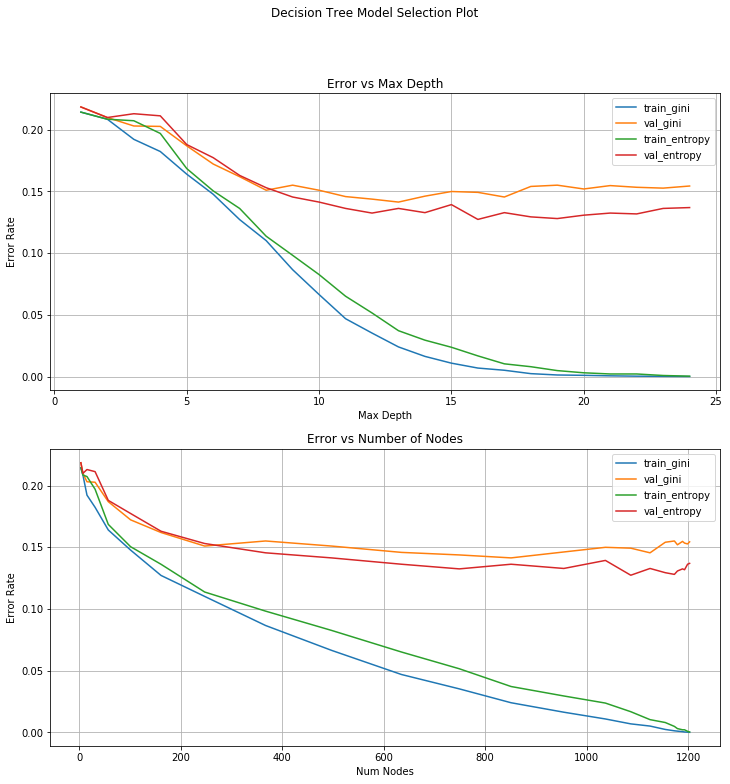

In [37]:
train_df, validate_df, test_df = get_train_val_test_df(df, 0.5, 0.2, 0.3)

X_train, y_train = extract_in_out(train_df)
X_validate, y_validate = extract_in_out(validate_df)
X_test, y_test = extract_in_out(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test)

As can be seen in the plot, our decision tree seems to work. There is little difference between gini and entropy and the plots using number of nodes and maxdepth. I will use GINI index from here on out and just plot max depth. Now, let's try to add several different preprocessing techniques to see if we can improve performance.

In [38]:
def run(X_train, y_train, X_validate, y_validate, X_test, y_test):

    train_gini_errors = []
    val_gini_errors = []
    max_depth = list(range(1,25))
    num_gini_nodes = []
    for md in max_depth:
        clf_gini_tree = DecisionTreeClassifier(criterion='gini', max_depth=md, random_state=1)
        clf_gini_tree.fit(X_train, y_train)
        num_gini_nodes.append(clf_gini_tree.tree_.node_count)
        train_gini_errors.append(1-clf_gini_tree.score(X_train, y_train))
        val_gini_errors.append(1-clf_gini_tree.score(X_validate, y_validate))

    fig, axes = plt.subplots(1,1, squeeze=False, figsize=(8,6))
    fig.suptitle("Decision Tree Model Selection Plot")
    axes[0,0].set_title("Error vs Max Depth")
    axes[0,0].plot(max_depth, train_gini_errors, label="train_gini")
    axes[0,0].plot(max_depth, val_gini_errors, label="val_gini")
    axes[0,0].legend()
    axes[0,0].grid(True)
    axes[0,0].set_xlabel("Max Depth")
    axes[0,0].set_ylabel("Error Rate")

Let's add principal component analysis, feature creation (by averaging the evi data).

In [39]:
def pca(df, comps):
    """Perform principal compenent analysis on the evi data columns and keep the first comps components
    """
    data_cols = []
    other_cols = []
    for col in df.columns:
        if re.match(r"[0-9]", col[0]):
            data_cols.append(col)
        else:
            other_cols.append(col)
    data = df.loc[:, data_cols].to_numpy()
    pca_ = PCA(n_components=comps)
    pca_.fit(data)
    print(f"Explained_variance_ratio : {pca_.explained_variance_ratio_}")
    transformed = pca_.transform(data)
    new_df = df.loc[:, other_cols]
    for i in range(comps):
        new_df[str(i)] = transformed[:, i]
    return new_df

In [40]:
def scale_evi(df, s_type, s_all):
    """Scale the dataframe by either min max scaling or standard normalization.
    
    Allow to scale each column independently or scale the entire evi data as a whole.
    """
    def min_max(x, minx, maxx):
        return (x-minx)/(maxx-minx)

    def standard(x, meanx, stdx):
        return (x-meanx)/stdx

    def get_min_max(data):
        mini, maxi = data[0, 0], data[0, 0]
        for row in data:
            tmi = min(row)
            tma = max(row)
            if tmi < mini:
                mini = tmi
            if tma > maxi:
                maxi = tma
        return mini, maxi

    def get_mean_std(data):
        data_flat = data.flatten()
        return np.mean(data_flat), np.std(data_flat)

    if s_type == "minmax":
        if s_all:
            data_cols = []
            for col in df.columns:
                if re.match(r"[0-9]", col[0]):
                    data_cols.append(col)
            data = df.loc[:, data_cols].to_numpy()
            mini, maxi = get_min_max(data)
            for col in df.columns:
                if re.match(r"[0-9]", col[0]):
                    vals = df[col].values
                    df[col] = (df[col] - mini) / (maxi-mini)
        else:
            for col in df.columns:
                if re.match(r"[0-9]", col[0]):
                    vals = df[col].values
                    mini = min(vals)
                    maxi = max(vals)
                    df[col] = (df[col] - mini) / (maxi-mini)
    else:
        if s_all:
            data_cols = []
            for col in df.columns:
                if re.match(r"[0-9]", col[0]):
                    data_cols.append(col)
            data = df.loc[:, data_cols].to_numpy()
            mean, std = get_mean_std(data)
            for col in df.columns:
                if re.match(r"[0-9]", col[0]):
                    vals = df[col].values
                    df[col] = (df[col] - mean) / std
        else:
            for col in df.columns:
                if re.match(r"[0-9]", col[0]):
                    vals = df[col].values
                    mean = np.mean(vals)
                    std = np.std(vals)
                    df[col] = (df[col] - mean) / std

    return df

In [41]:
def create_ave(df, y_ave, m_ave, c_ave, weights):
    """Average the dataframe's evi data.
    
    Can either average by:
    year (two dates that are only one day apart are averaged)
    month (average each month after averaging for years)
    continuous - can either use 2 or 3 datapoint averages and can weight the datapoints with weights
               - 2 data point weights weights the current point with weights[0] and the previous with weights[1]+weights[2]
               - 3 data point weights current with weights[0], previous with weights[1] and next with weights[2]
               - 2 date uses the current datapoint and the previous to create an average
               - 3 date uses the current, the next and the previous to create an average
    """
    if not y_ave and c_ave == 1 and not m_ave:
        return df
    other_columns = []
    date_columns = []
    days = []
    months = []
    new_df = pd.DataFrame()
    for col in df.columns:
        if re.match(r"201[1-2]-[0-1][0-9]-[0-3][0-9]", col):
            if col[:4] == "2012":
                col = col[:8] + str(int(col[-2:])+1).zfill(2)
            date_columns.append(col)
            if col[5:7] not in months:
                months.append(col[5:7])
            if col[5:] not in days:
                days.append(col[5:])
        else:
            other_columns.append(col)
    df.columns = other_columns + date_columns
    for col in other_columns:
        new_df[col] = df[col]
    if y_ave:
        if not m_ave and c_ave == 1:
            for day in days:
                new_df[day] = (df["2011-"+day] + df["2012-"+day] ) / 2
        elif c_ave > 1 and not m_ave:
            temp_df = pd.DataFrame()
            for day in days:
                temp_df[day] = (df["2011-"+day] + df["2012-"+day] ) / 2
            if c_ave == 2:
                for i in range(1, len(temp_df.columns)):
                    new_df[str(i)] = weights[0]*temp_df.iloc[:, i] + (weights[1]+weights[2])*temp_df.iloc[:, i-1]
            elif c_ave == 3:
                for i in range(1, len(temp_df.columns)-1):
                    new_df[str(i)] = weights[0]*temp_df.iloc[:, i] + weights[1]*temp_df.iloc[:, i-1] + weights[2]*temp_df.iloc[:, i+1]
            else:
                raise ValueError("Rolling average is 2 or 3")
        elif m_ave and c_ave == 1:
            for month in months:
                dates = []
                for col in df.columns:
                    if month == col[5:7]:
                        dates.append(col)
                if len(dates) > 0:
                    new_df[month] = df[dates[0]]
                    for i in range(1, len(dates), 1):
                        new_df[month] = new_df[month] + df[dates[i]]

                    if len(dates) > 1:
                        new_df[month] = new_df[month] / len(dates)
        else:
            raise ValueError("Cannot monthly average and rolling averrage")
    else:
        if c_ave > 1 and not m_ave:
            temp_df = pd.DataFrame()
            for day in days:
                temp_df[day] = (df["2011-"+day] + df["2012-"+day] ) / 2
            if c_ave == 2:
                for i in range(1, len(temp_df.columns)):
                    new_df[str(i)] = weights[0]*temp_df.iloc[:, i] + weights[1]*temp_df.iloc[:, i-1]
            elif c_ave == 3:
                for i in range(1, len(temp_df.columns)-1):
                    new_df[str(i)] = weights[0]*temp_df.iloc[:, i] + weights[1]*temp_df.iloc[:, i-1] + weights[2]*temp_df.iloc[:, i+1]
            else:
                raise ValueError("Rolling average is 2 or 3")
        elif m_ave and c_ave == 1 and False:
            for month in months:
                dates = []
                for col in df.columns:
                    if month == col[5:7]:
                        dates.append(col)
                if len(dates) > 0:
                    new_df[month] = df[dates[0]]
                    for i in range(1, len(dates), 1):
                        new_df[month] = new_df[month] + df[dates[i]]

                    if len(dates) > 1:
                        new_df[month] = new_df[month] / len(dates)
        else:
            raise ValueError("Cannot monthly average and rolling averrage")

    return new_df



Now lets test if these improve performance at all

First up is yearly average

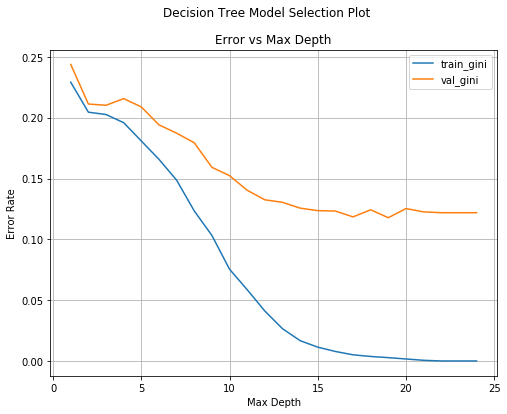

In [42]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

ave_df = create_ave(df, y_ave=True, m_ave=False, c_ave=1, weights=[0,0,0])

train_df, validate_df, test_df = get_train_val_test_df(ave_df, 0.5, 0.2, 0.3)

X_train, y_train = extract_in_out(train_df)
X_validate, y_validate = extract_in_out(validate_df)
X_test, y_test = extract_in_out(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test)

Next up is monthly average.

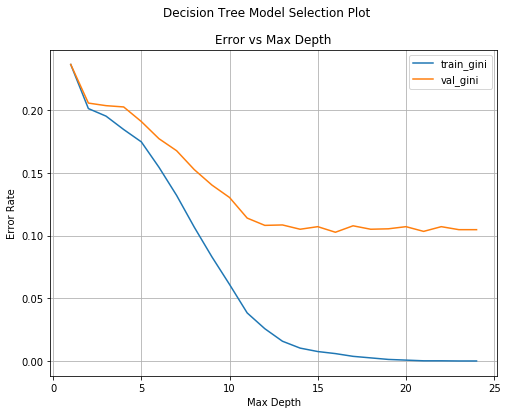

In [43]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

ave_df = create_ave(df, y_ave=True, m_ave=True, c_ave=1, weights=[0,0,0])

train_df, validate_df, test_df = get_train_val_test_df(ave_df, 0.5, 0.2, 0.3)

X_train, y_train = extract_in_out(train_df)
X_validate, y_validate = extract_in_out(validate_df)
X_test, y_test = extract_in_out(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test)

How about continous average (first 2 day and then 3 day) with weights [1/2, 1/4, 1/4]

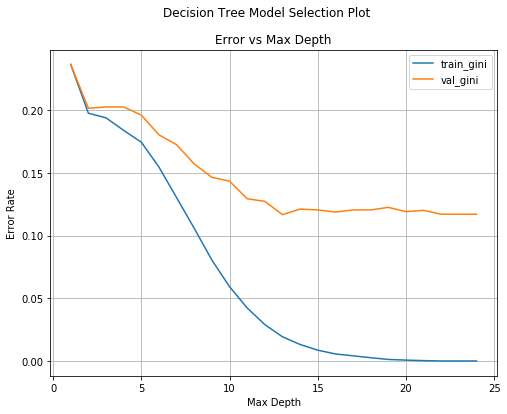

In [44]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

ave_df = create_ave(df, y_ave=True, m_ave=False, c_ave=2, weights=[1/2,1/4,1/4])

train_df, validate_df, test_df = get_train_val_test_df(ave_df, 0.5, 0.2, 0.3)

X_train, y_train = extract_in_out(train_df)
X_validate, y_validate = extract_in_out(validate_df)
X_test, y_test = extract_in_out(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test)

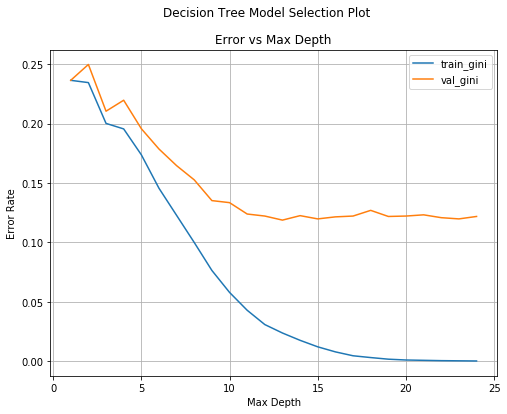

In [45]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

ave_df = create_ave(df, y_ave=True, m_ave=False, c_ave=3, weights=[1/2,1/4,1/4])

train_df, validate_df, test_df = get_train_val_test_df(ave_df, 0.5, 0.2, 0.3)

X_train, y_train = extract_in_out(train_df)
X_validate, y_validate = extract_in_out(validate_df)
X_test, y_test = extract_in_out(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test)

Now let's see how pca affects the performance.

In [46]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

pca_df = scale_evi(df, s_type="minmax", s_all=False)
pca_df = pca(pca_df, comps=5)



Explained_variance_ratio : [0.2528806  0.2136267  0.16701574 0.09535501 0.0739937 ]


Looks like we only need 3 components.

Explained_variance_ratio : [0.2528806  0.2136267  0.16701574 0.09535501 0.0739937  0.03059138
 0.02592182 0.02155563 0.01524343 0.01380455 0.01327414 0.01230236
 0.01190884 0.01084778 0.01069088 0.00905901 0.0079604  0.00583436
 0.00497271 0.00316095]


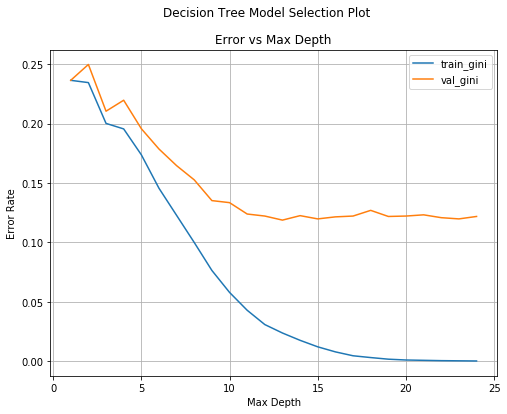

In [47]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

pca_df = scale_evi(df, s_type="minmax", s_all=False)
pca_df = pca(pca_df, comps=20)

train_df, validate_df, test_df = get_train_val_test_df(ave_df, 0.5, 0.2, 0.3)

X_train, y_train = extract_in_out(train_df)
X_validate, y_validate = extract_in_out(validate_df)
X_test, y_test = extract_in_out(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test)

After some fine tuning on this setup and checking various parameters, I created my best model below.

Explained_variance_ratio : [0.3712082]


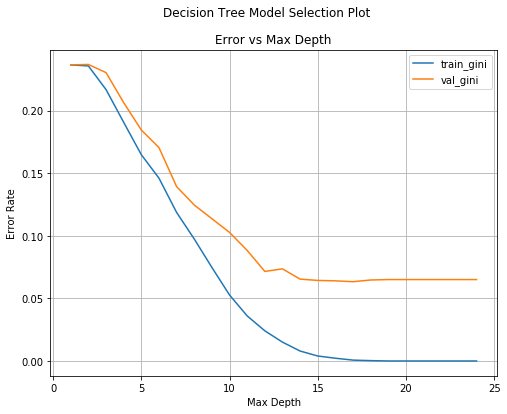

In [48]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

ave_df = create_ave(df, y_ave=True, m_ave=False, c_ave=1, weights=[1/3,1/3,1/3])

pca_df = scale_evi(ave_df, s_type="minmax", s_all=False)
pca_df = pca(pca_df, comps=1)

train_df, validate_df, test_df = get_train_val_test_df(pca_df, 0.5, 0.2, 0.3)

X_train, y_train = extract_in_out(train_df)
X_validate, y_validate = extract_in_out(validate_df)
X_test, y_test = extract_in_out(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test)

My fear with this model (particularly noted by the training error going to 0 for max depth greater than 15) is that this model is learning based off the latitude and longitude too much. The lat/lon position in some ways are similar to an id attribute, as it unique defines a position, however that does not mean it has much information for another position based on lat/lon. Mainly what latitude and longitude should be telling us is how it would correlate to the evi values of the fields. For example, a lat/lon in Alabama should expect different evi values for rainfed versus irrigated as compared to the a lat/lon that corresponds to Arizona's evi values for rainfed and irrigated. To combat this, I decided to one-hot-encode the county so that I could know what county I was in, and then dropped the lat/lon attributes. I think this creates a more generalized model as well as a more realistic model, as it is using a coarse location (county) and then bases its prediction purely off of the evi values after that.

In [49]:
def one_hot_encode_df(df):
    """Create one hot encoding columns for the counties and then drop the latitude and longitude columns
    """
    one_hot = pd.get_dummies(df["county"])
    df = df.join(one_hot)
    df.drop(columns=["Latitude", "Longitude"], inplace=True)
    return df

Note that we have to reorder the dataframe columns as the create_ave function requires that all non evi data columns come before the evi data columns.

In [50]:
def reorder_df(df):
    evi_cols = []
    other_cols = []
    for col in df.columns:
        if re.match(r"[0-9]", col[0]):
            evi_cols.append(col)
        else:
            other_cols.append(col)
    cols = other_cols+evi_cols
    return df[cols]

Explained_variance_ratio : [0.3712082]


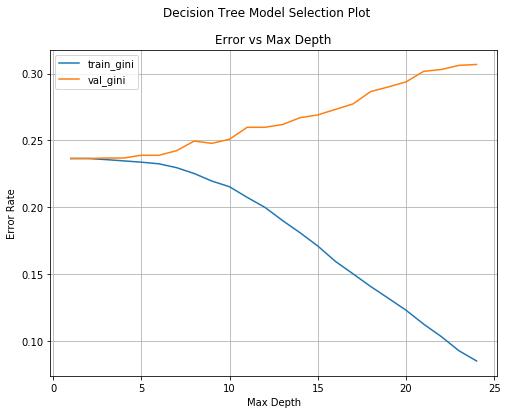

In [51]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

one_hot_df = one_hot_encode_df(df)

df_reorder = reorder_df(one_hot_df)

ave_df = create_ave(df_reorder, y_ave=True, m_ave=False, c_ave=1, weights=[1/3,1/3,1/3])

pca_df = scale_evi(ave_df, s_type="minmax", s_all=False)
pca_df = pca(pca_df, comps=1)

train_df, validate_df, test_df = get_train_val_test_df(pca_df, 0.5, 0.2, 0.3)

X_train, y_train = extract_in_out(train_df)
X_validate, y_validate = extract_in_out(validate_df)
X_test, y_test = extract_in_out(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test)

As can be seen by the plot above, the performance is much weaker with a one_hot_encoded dataset. This demonstrates that the previous model was mostly modeling the latitude and longitude position and not particularly modeling the evi data. In order to fix this problem, I will one-hot-encode the single target column to rf and irr columns and then use a weighted error for the target class based on the frequency of label.

In [52]:
def extract_in_out_split(df):
    """Return a numpy array for the input data and the target values for use with sklearn
    """
    x_in = df.drop(columns=["rf", "irr", "county"]).to_numpy()
    y_out = df.loc[:, ["rf", "irr"]].to_numpy()
    return x_in, y_out

In [53]:
def run(X_train, y_train, X_validate, y_validate, X_test, y_test, **kwargs):

    train_gini_errors = []
    val_gini_errors = []
    max_depth = list(range(1,35))
    num_gini_nodes = []
    for md in max_depth:
        clf_gini_tree = DecisionTreeClassifier(criterion='gini', max_depth=md, random_state=1, **kwargs)
        clf_gini_tree.fit(X_train, y_train)
        num_gini_nodes.append(clf_gini_tree.tree_.node_count)
        train_gini_errors.append(1-clf_gini_tree.score(X_train, y_train))
        val_gini_errors.append(1-clf_gini_tree.score(X_validate, y_validate))

    fig, axes = plt.subplots(1,1, squeeze=False, figsize=(8,6))
    fig.suptitle("Decision Tree Model Selection Plot")
    axes[0,0].set_title("Error vs Max Depth")
    axes[0,0].plot(max_depth, train_gini_errors, label="train_gini")
    axes[0,0].plot(max_depth, val_gini_errors, label="val_gini")
    axes[0,0].legend()
    axes[0,0].grid(True)
    axes[0,0].set_xlabel("Max Depth")
    axes[0,0].set_ylabel("Error Rate")

Rechecking our old performance with our "strong" learner with the new weighted error produces the following result.

Explained_variance_ratio : [0.3712082]


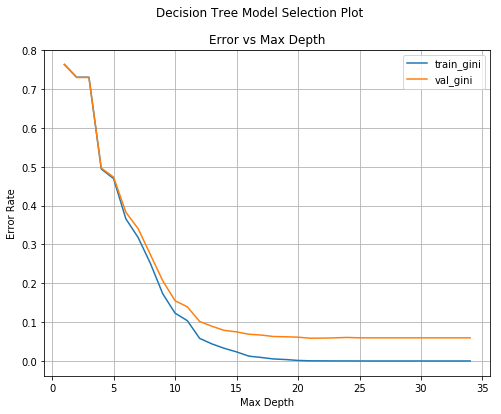

In [54]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

one_hot_rf_irr = pd.get_dummies(df["rf_irr"])
one_hot_rf_irr.columns = ["rf", "irr"]
df_rf_irr = df.join(one_hot_rf_irr)

df_rf_irr.drop(columns=["rf_irr"], inplace=True)

df_reorder = reorder_df(df_rf_irr)

ave_df = create_ave(df_reorder, y_ave=True, m_ave=False, c_ave=1, weights=[1/3,1/3,1/3])

pca_df = scale_evi(ave_df, s_type="minmax", s_all=False)
pca_df = pca(pca_df, comps=1)

train_df, validate_df, test_df = get_train_val_test_df(pca_df, 0.5, 0.2, 0.3, targets=["rf", "irr"])

X_train, y_train = extract_in_out_split(train_df)
X_validate, y_validate = extract_in_out_split(validate_df)
X_test, y_test = extract_in_out_split(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test, class_weight="balanced")

Note now that the error starts at about 75% and drops down to about 5%. The problem with the lat/lon is still persistent but now we can see that the weighted error has significantly changed our error rate. Now let's drop the latitude, longitude columns and try again to model the data.

Explained_variance_ratio : [0.23253348 0.17341274 0.14751976]


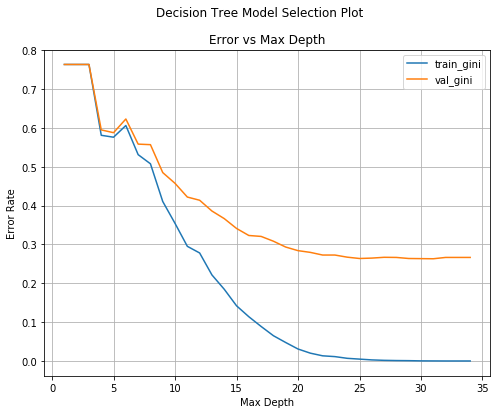

In [55]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

one_hot_rf_irr = pd.get_dummies(df["rf_irr"])
one_hot_rf_irr.columns = ["rf", "irr"]
df_rf_irr = df.join(one_hot_rf_irr)

one_hot_df = one_hot_encode_df(df_rf_irr)

one_hot_df.drop(columns=["rf_irr"], inplace=True)

df_reorder = reorder_df(one_hot_df)

ave_df = create_ave(df_reorder, y_ave=False, m_ave=False, c_ave=1, weights=[1/3,1/3,1/3])

pca_df = scale_evi(ave_df, s_type="minmax", s_all=True)
pca_df = pca(pca_df, comps=3)

train_df, validate_df, test_df = get_train_val_test_df(pca_df, 0.5, 0.2, 0.3, targets=["rf", "irr"])

X_train, y_train = extract_in_out_split(train_df)
X_validate, y_validate = extract_in_out_split(validate_df)
X_test, y_test = extract_in_out_split(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test, class_weight="balanced")

This is still not that great. The one-hot-encoded columns to tell us what county we are in are not neccesary. Let's try dropping those features and then try various class weights. The eventual best performance is shown below.

In [56]:
class_weights = [{0: 1, 1: 1}, {0: 1, 1: 1.5}]

Explained_variance_ratio : [0.2528806  0.2136267  0.16701574]


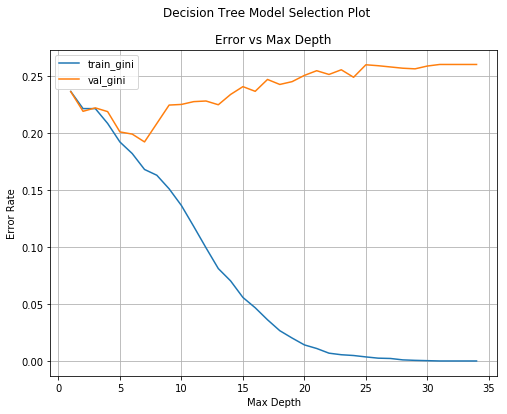

In [57]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "cleaned_data", "all_data.csv"), index_col=0)

one_hot_rf_irr = pd.get_dummies(df["rf_irr"])
one_hot_rf_irr.columns = ["rf", "irr"]
df_rf_irr = df.join(one_hot_rf_irr)
df_rf_irr.drop(columns=["rf_irr"], inplace=True)

df_no_lat_lon = df_rf_irr.drop(columns=["Latitude", "Longitude"])

df_reorder = reorder_df(df_no_lat_lon)

ave_df = create_ave(df_reorder, y_ave=False, m_ave=False, c_ave=1, weights=[3/4,1/8,1/8])

pca_df = scale_evi(ave_df, s_type="minmax", s_all=False)
pca_df = pca(pca_df, comps=3)

train_df, validate_df, test_df = get_train_val_test_df(pca_df, 0.5, 0.25, 0.25, targets=["rf", "irr"])

X_train, y_train = extract_in_out_split(train_df)
X_validate, y_validate = extract_in_out_split(validate_df)
X_test, y_test = extract_in_out_split(test_df)

run(X_train, y_train, X_validate, y_validate, X_test, y_test, class_weight=class_weights)

The graph shows that initially we are underfitting the data. The train and val both decrease with error rate as complexity increases. Then, at about a max depth of 7, we start to see overfitting come into play. As evidenced by the fact the validation performance decreases while the train performance increases for increased complexity. Therefore, a max depth of 5-7 appears to be our best model. Now, to test the model performance on the test set.

In [68]:
clf_gini_tree = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=1, class_weight=class_weights)
clf_gini_tree.fit(X_train, y_train)
predictions = clf_gini_tree.predict(X_test)

In [69]:
def calc_conf_mat(predictions, actual):
    """Calculate confusion matrix
    """
    conf_mat = np.zeros((2,2), dtype=int)
    for i in range(len(predictions)):
        if np.all(predictions[i] == actual[i]) and actual[i, 1] == 1:
            conf_mat[1,1] += 1
        elif np.all(predictions[i] == actual[i]) and actual[i, 0] == 1:
            conf_mat[0,0] += 1
        elif not np.all(predictions[i] == actual[i]) and predictions[i, 0] == 0:
            conf_mat[1,0] += 1
        else:
            conf_mat[0,1] += 1
    return conf_mat

def print_conf_mat(conf_mat):
    """Print confusion matrix
    """
    print("                        Actual Class")
    print("                     Rainfed | Irrigated")
    print(f"Predicted Rainfed   |  {conf_mat[0,0]:<4}  |  {conf_mat[0,1]:<4}  ")
    print(f"Predicted Irrigated |  {conf_mat[1,0]:<4}  |  {conf_mat[1,1]:<4}  ")

In [70]:
def score(conf_mat):
    """Return the score for a confusion matrix.
    """
    return (conf_mat[0,0] + conf_mat[1,1]) / (conf_mat[0,0] + conf_mat[1,1] + conf_mat[1,0] + conf_mat[0,1])


In [71]:
conf_mat = calc_conf_mat(predictions, y_test)
print_conf_mat(conf_mat)
print(score(conf_mat))

                        Actual Class
                     Rainfed | Irrigated
Predicted Rainfed   |  2643  |  573   
Predicted Irrigated |  147   |  294   
0.8031173092698933


Comparing this to a naive model that always predicts rainfed, we see that we are not beating the naive model.

In [72]:
naive_predictions = np.array([np.array([1,0]) for i in range(len(y_test))])
conf_mat = calc_conf_mat(naive_predictions, y_test)
print_conf_mat(conf_mat)
print(score(conf_mat))

                        Actual Class
                     Rainfed | Irrigated
Predicted Rainfed   |  2790  |  867   
Predicted Irrigated |  0     |  0     
0.7629204265791633


In the end, after much testing and tuning, my model is barely an improvement over just predicting rainfed for each data point. Attempting to yearly average, monthly average or moving average the data points added no benefit. One-hot-encoding the counties added no benefit. Using PCA did not improve the performance, but did significantly improve runtimes and reduced the model complexity needed. The first 3 principal components are able to capture enough of the pattern in the data to not reduce performance at all. I also tried using weights to help the model predict irrigated more often (since the irrigated class is much less frequent than the rainfed class) but this did not add significant benefit. My final model was only able to achieve an accuracy of about 80% on the data, hardly better than the 76% of the rainfed data.